# Εργασία 2 (Τεχνικές Εξόρυξης Δεδομένων)
## Data Mining: Assignment 2
***
### Μαρία Φριτζελά 1115201400218
***

In [101]:
import glob
import csv
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

Κατηγοριοποίηση δεδομένων κειμένου από ειδησιογραφικά άρθρα 5 κατηγοριών:</br>
Classifying text data from articles of 5 different categories:

In [102]:
categories = ['business', 'entertainment', 'politics', 'sport', 'tech']

### Get names of files for testing and training
Data set consists of 2225 documents from a news website
corresponding to stories in five topical areas from 2004-2005.</br>
</br>
80% of data points (files) will be used for training, the remaining 20% will be used for testing.</br>
We will be collecting the files names as elements in two lists (one for each purpose)

In [103]:
files_path = 'fulltext/data/'
train_files = []    # list of files names that will be used for training
test_files = []     # list of files names that will be used for testing

for category in categories:
    # get all txt files names from current category
    files = glob.glob(files_path+category+'/*.txt')
    # sort them alphabetically
    files.sort()
    # separate list so that first 80% will be copied into the train_files list
    sep_index = round(len(files) * 0.8)
    train_files.extend(files[:sep_index])
    test_files.extend(files[sep_index:])

Result:

In [104]:
print("Total files: 2225")
print("# of train files: "+str(len(train_files)))
print("# of test files: "+str(len(test_files)))

Total files: 2225
# of train files: 1781
# of test files: 444


### Create file train_set.tsv
Columns: id, title, content, category <br>
_The id is the name of the text file with the first letter of the category prepended (ex. "b001")_

In [105]:
with open('train_set.tsv', 'wt') as out_file:
    tsv_writer = csv.writer(out_file, delimiter='\t')
    # write header row
    tsv_writer.writerow(['id', 'title', 'content', 'category'])
    # write rows for all other files
    for file_path in train_files:
        with open(file_path) as f:
            # read all lines of file split them in a list removing '\n'
            # iterate through elements in list removing empty ones (empty strings are False)
            try:
                content = [line for line in f.read().splitlines() if line.strip()]
                # unpack the information we need from the file path
                _, _, cat, name, _ = file_path.replace('.', '/').split('/')
                # Write row
                tsv_writer.writerow([cat[0]+name,
                                 content.pop(0),
                                 " ".join(content),
                                 cat])
            except UnicodeDecodeError:
                print("UnicodeDecodeError for file: "+file_path+". File skipped")


UnicodeDecodeError for file: fulltext/data/sport/199.txt. File skipped


### Create file test_set.tsv
Columns: id, title, content

In [106]:
with open('test_set.tsv', 'wt') as out_file:
    tsv_writer = csv.writer(out_file, delimiter='\t')
    # write header row
    tsv_writer.writerow(['id', 'title', 'content'])
    # write rows for all other files
    for file_path in test_files:
        with open(file_path) as f:
            # read all lines of file split them in a list removing '\n'
            # iterate through elements in list removing empty ones (empty strings are False)
            try:
                content = [line for line in f.read().splitlines() if line.strip()]
                # unpack the information we need from the file path
                _, _, cat, name, _ = file_path.replace('.', '/').split('/')
                # Write row
                tsv_writer.writerow([cat[0]+name,
                                 content.pop(0),
                                 " ".join(content)])
            except UnicodeDecodeError:
                print("UnicodeDecodeError for file: "+file_path+". File skipped")

Create a DataFrame for the test_set and the train_set (id column as the index)

In [107]:
testdf = pd.read_csv("test_set.tsv", sep='\t', index_col='id')
traindf = pd.read_csv("train_set.tsv", sep='\t', index_col='id')

## 1 Δημιουργία WordCloud
**Create a WordCloud for the articles of each category**

In [130]:
# Create our own stopWord list:
stopwords = set(STOPWORDS)
stopwords.update(['say', 'said', 'will', 'many', 'new', 'people', 'now', 'one'])

### Business

In [131]:
#create wordcloud
wordcloud_business = WordCloud(
    width = 800,
    height = 800,
    background_color = 'black',
    stopwords = stopwords).generate(" ".join(title+' '+content
                                             for title, content in traindf.append(testdf).filter(like='b', axis=0)
                                                                   [['title', 'content']].values.tolist()))
# select rows where the id contains 'b' (=business)
'''
wordcloud_business2 = WordCloud(
    width = 800,
    height = 800,
    background_color = 'black',
    stopwords = stopwords).generate(str(traindf.append(testdf).filter(like='b', axis=0)[['title', 'content']].values))
'''

"\nwordcloud_business2 = WordCloud(\n    width = 800,\n    height = 800,\n    background_color = 'black',\n    stopwords = stopwords).generate(str(traindf.append(testdf).filter(like='b', axis=0)[['title', 'content']].values))\n"

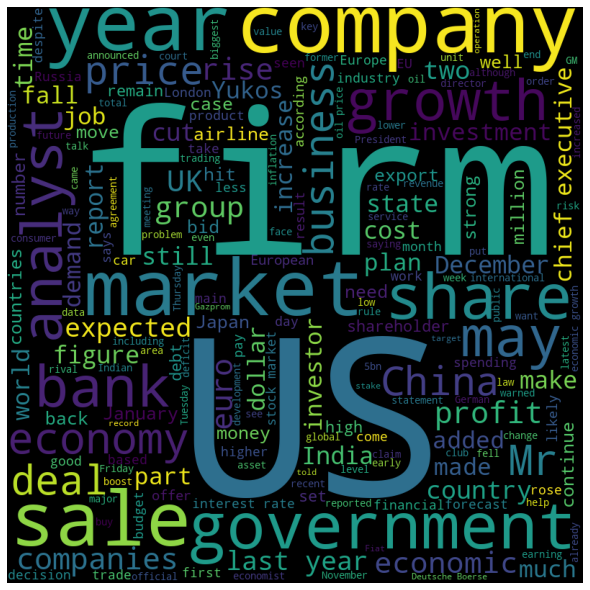

In [132]:
#show it
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_business)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

### Entertainment

In [133]:
wordcloud_entertainment = WordCloud(
    width = 800,
    height = 800,
    background_color = 'black',
    stopwords = stopwords).generate(str(traindf.append(testdf).filter(like='e', axis=0)[['title', 'content']].values))

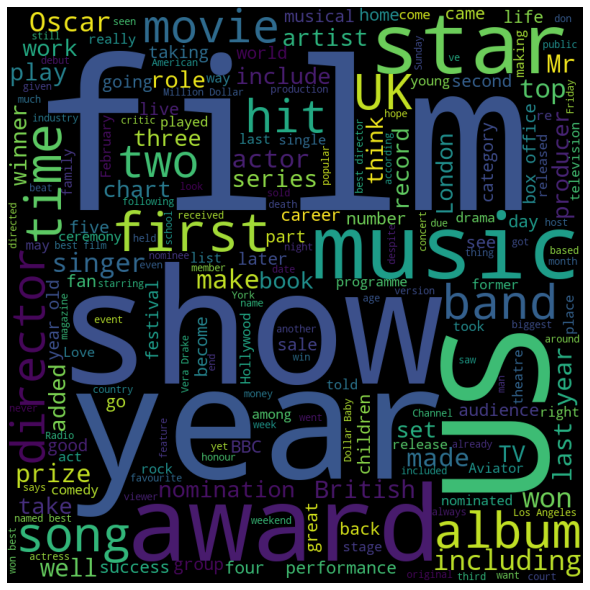

In [134]:
#show it
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_entertainment)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

### Politics

In [135]:
wordcloud_politics = WordCloud(
    width = 800,
    height = 800,
    background_color = 'black',
    stopwords = stopwords).generate(str(traindf.append(testdf).filter(like='p', axis=0)[['title', 'content']].values))

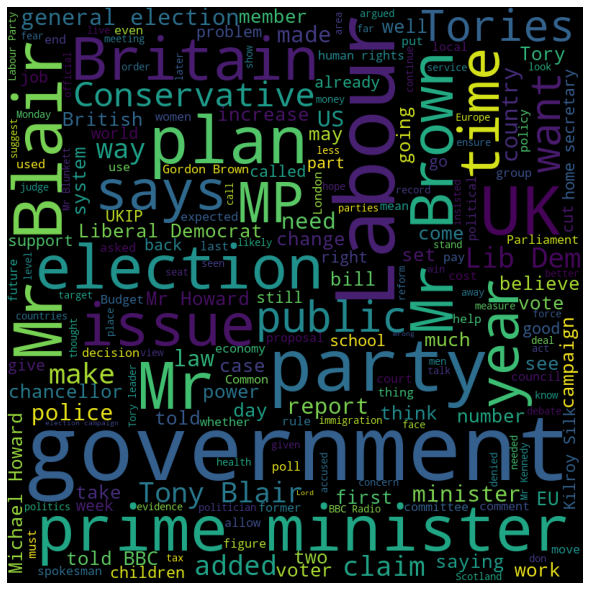

In [136]:
#show it
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_politics)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

### Sport

In [137]:
wordcloud_sport = WordCloud(
    width = 800,
    height = 800,
    background_color = 'black',
    stopwords = stopwords).generate(str(traindf.append(testdf).filter(like='s', axis=0)[['title', 'content']].values))

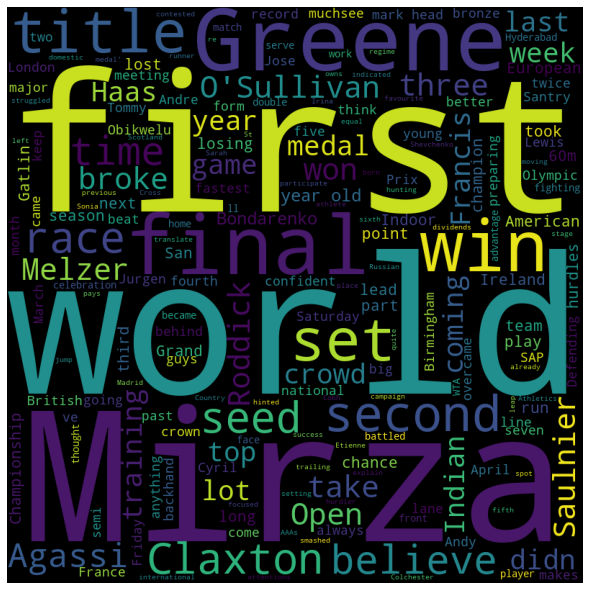

In [138]:
#show it
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_sport)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

### Tech

In [139]:
wordcloud_tech = WordCloud(
    width = 800,
    height = 800,
    background_color = 'black',
    stopwords = stopwords).generate(str(traindf.append(testdf).filter(like='t', axis=0)[['title', 'content']].values))

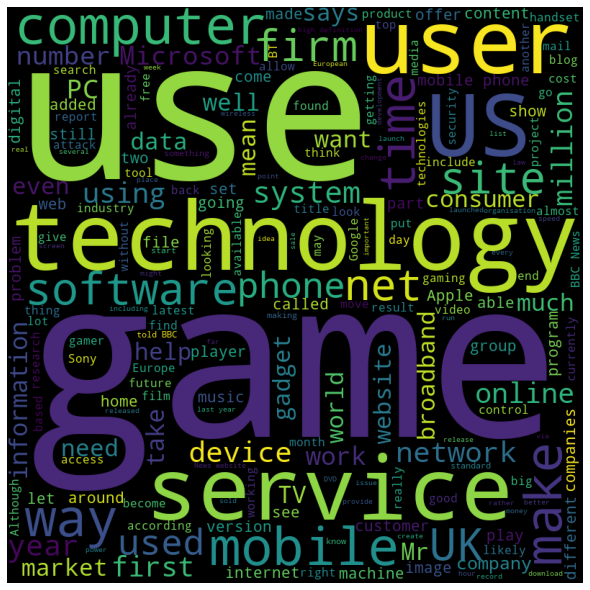

In [140]:
#show it
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_tech)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()
